In [ ]:
### reference 
1. https://github.com/jacobgil/keras-dcgan
2. https://github.com/Zackory/Keras-MNIST-GAN
3. https://oshearesearch.com/index.php/2016/07/01/mnist-generative-adversarial-model-in-keras/

In [12]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist

# DC-GAN
# Discriminator
D = Sequential()
D.add(Conv2D(64, (5, 5), input_shape=(28, 28, 1), padding='same'))
D.add(Activation('tanh'))
D.add(MaxPooling2D(pool_size=(2, 2)))
D.add(Conv2D(128, (5, 5)))
D.add(Activation('tanh'))
D.add(MaxPooling2D(pool_size=(2, 2)))
D.add(Flatten())
D.add(Dense(1024))
D.add(Activation('tanh'))
D.add(Dense(1))
D.add(Activation('sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 128)       204928    
_________________________________________________________________
activation_18 (Activation)   (None, 10, 10, 128)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
__________

In [13]:
optimizer = SGD(lr=0.0005, momentum=0.9, nesterov=True)
d = Sequential()
d.add(D)
d.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
)

In [14]:
# Generator
G = Sequential()
G.add(Dense(input_dim=100, output_dim=1024))
G.add(Activation('tanh'))
G.add(Dense((128*7*7)))
G.add(BatchNormalization())
G.add(Activation('tanh'))
G.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(64, (5, 5), padding='same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('tanh'))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(1, (5, 5), padding='same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('tanh'))
G.summary()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1024, input_dim=100)`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1024)              103424    
_________________________________________________________________
activation_21 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_7 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_22 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 128)       0         
__________

In [15]:
optimizer = SGD(lr=0.0005, momentum=0.9, nesterov=True)
gan = Sequential()
gan.add(G)
gan.add(D)
gan.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
)

In [16]:
from keras.datasets import mnist

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype(np.float32)
print X_train.shape

train_steps = 20
batch_size = 256

for i in range(train_steps):
    images_train = X_train[np.random.randint(0, X_train.shape[0], size=batch_size), :, :, :]
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    images_fake = G.predict(noise)
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0
    d_loss = d.train_on_batch(x, y)
    
    y = np.ones([batch_size, 1])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    D.trainable = False
    a_loss = gan.train_on_batch(noise, y)
    D.trainable = True
    log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
    log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
    print(log_mesg)

(60000, 28, 28, 1)
0: [D loss: 0.583367, acc: 0.496094]  [A loss: 0.604212, acc: 0.976562]
1: [D loss: 0.546788, acc: 0.503906]  [A loss: 0.575320, acc: 0.996094]
2: [D loss: 0.500914, acc: 0.500000]  [A loss: 0.545804, acc: 0.996094]
3: [D loss: 0.472721, acc: 0.500000]  [A loss: 0.513301, acc: 1.000000]
4: [D loss: 0.455950, acc: 0.500000]  [A loss: 0.481379, acc: 1.000000]
5: [D loss: 0.443843, acc: 0.500000]  [A loss: 0.444077, acc: 1.000000]
6: [D loss: 0.440788, acc: 0.500000]  [A loss: 0.415433, acc: 1.000000]
7: [D loss: 0.444705, acc: 0.500000]  [A loss: 0.382110, acc: 1.000000]
8: [D loss: 0.447295, acc: 0.500000]  [A loss: 0.357795, acc: 1.000000]
9: [D loss: 0.455970, acc: 0.500000]  [A loss: 0.331149, acc: 1.000000]
10: [D loss: 0.468715, acc: 0.500000]  [A loss: 0.305784, acc: 1.000000]
11: [D loss: 0.481129, acc: 0.500000]  [A loss: 0.284499, acc: 1.000000]
12: [D loss: 0.492954, acc: 0.500000]  [A loss: 0.265609, acc: 1.000000]
13: [D loss: 0.507070, acc: 0.500000]  [A 

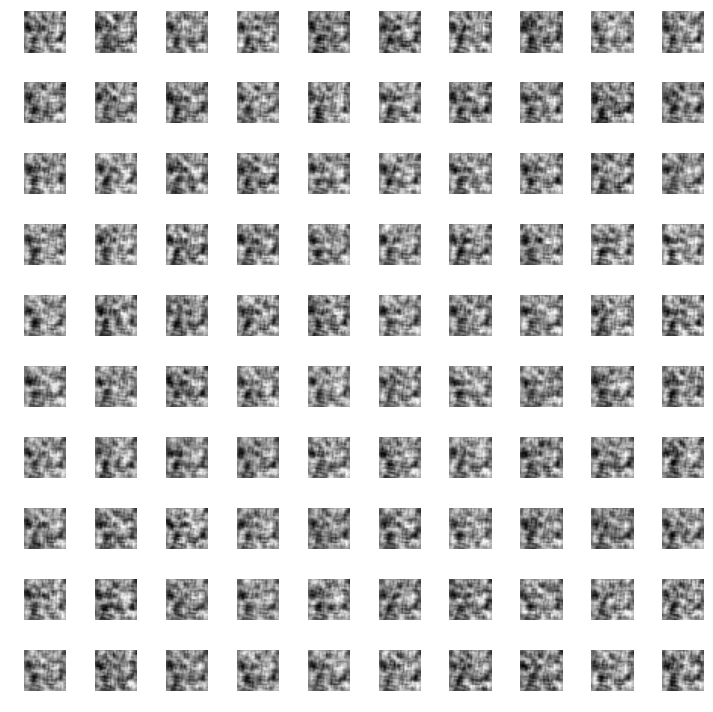

In [17]:
import matplotlib.pyplot as plt

try_input = np.random.rand(100, 100)
preds = G.predict(try_input)
plt.figure(figsize=(10,10))
for i in range(preds.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(preds[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()